### Import libraries

In [53]:
import os
import numpy as np
import pandas as pd
import glob as gb
import cv2
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from tensorflow import keras
from keras import layers
from keras import models
from keras import Input
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import seaborn as sns

In [3]:
train_dataset_path = r"D:\Project\PG Project\Data\Image Data\seg_train"

test_dataset_path = r"D:\Project\PG Project\Data\Image Data\seg_test"

predict_dataset_path = r"D:\Project\PG Project\Data\Image Data\seg_pred\seg_pred"

### Checking data information

In [5]:
train_dataset_checking_path = os.path.join(train_dataset_path, 'seg_train')

for folder in os.listdir(train_dataset_checking_path):
    folder_path = os.path.join(train_dataset_checking_path, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    print(f"For training data, found {len(files)} images in folder {folder}")
print()

test_dataset_checking_path = os.path.join(test_dataset_path, 'seg_test')

for folder in os.listdir(test_dataset_checking_path):
    folder_path = os.path.join(test_dataset_checking_path, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    print(f"For testing data, found {len(files)} images in folder {folder}")
print()

files = gb.glob(os.path.join(predict_dataset_path, '*.jpg'))
print(f"For predicting data, found {len(files)} images")

For training data, found 2190 images in folder buildings
For training data, found 2263 images in folder forest
For training data, found 2387 images in folder glacier
For training data, found 2495 images in folder mountain
For training data, found 2270 images in folder sea
For training data, found 2381 images in folder street

For testing data, found 437 images in folder buildings
For testing data, found 473 images in folder forest
For testing data, found 549 images in folder glacier
For testing data, found 523 images in folder mountain
For testing data, found 510 images in folder sea
For testing data, found 501 images in folder street

For predicting data, found 7288 images


In [6]:
size = []
for folder in os.listdir(train_dataset_checking_path):
    folder_path = os.path.join(train_dataset_checking_path, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
print(' Image size\t Count')
pd.Series(size).value_counts()

 Image size	 Count


(150, 150, 3)    13986
Name: count, dtype: int64

In [7]:
size = []
for folder in os.listdir(test_dataset_checking_path):
    folder_path = os.path.join(test_dataset_checking_path, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
print(' Image size\t Count')
pd.Series(size).value_counts()

 Image size	 Count


(150, 150, 3)    2993
Name: count, dtype: int64

In [8]:
size = []
files = gb.glob(os.path.join(predict_dataset_path, '*.jpg'))
for file in files: 
    image = plt.imread(file)
    size.append(image.shape)
print(' Image size\t Count')
pd.Series(size).value_counts()

 Image size	 Count


(150, 150, 3)    7288
Name: count, dtype: int64

### Retain (150,150,3)-sized images

In [10]:
Removed_image_dir = os.path.join(r'D:\项目\Comp702\Data\Image Data', 'Removed_train_images')
os.makedirs(Removed_image_dir, exist_ok=True)

moved_count1 = 0
moved_count2 = 0
moved_count3 = 0

for folder in os.listdir(train_dataset_checking_path):
    folder_path = os.path.join(train_dataset_checking_path, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    for file in files:
        with Image.open(file) as img:
            img = img.convert('RGB')  
            if img.size != (150, 150):
                new_name = f"{folder}_{os.path.basename(file)}"
                shutil.move(file, os.path.join(Removed_image_dir, new_name))
                moved_count1 += 1



for folder in os.listdir(test_dataset_checking_path):
    folder_path = os.path.join(test_dataset_checking_path, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    for file in files:
        with Image.open(file) as img:
            img = img.convert('RGB')
            if img.size != (150, 150):
                new_name = f"{folder}_{os.path.basename(file)}"
                shutil.move(file, os.path.join(Removed_image_dir, new_name))
                moved_count2 += 1


files = gb.glob(os.path.join(predict_dataset_path, '*.jpg'))
for file in files:
        with Image.open(file) as img:
            img = img.convert('RGB')
            if img.size != (150, 150):
                new_name = f"{folder}_{os.path.basename(file)}"
                shutil.move(file, os.path.join(Removed_image_dir, new_name))
                moved_count3 += 1

print(f"moving {moved_count1} train_images to {Removed_image_dir}")
print(f"moving {moved_count2} test_images to {Removed_image_dir}")
print(f"moving {moved_count3} predict_images to {Removed_image_dir}")

moving 0 train_images to D:\项目\Comp702\Data\Image Data\Removed_train_images
moving 0 test_images to D:\项目\Comp702\Data\Image Data\Removed_train_images
moving 0 predict_images to D:\项目\Comp702\Data\Image Data\Removed_train_images


### Label mapping

In [4]:
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


### Data loading

In [7]:
train_dir = r"D:\Project\PG Project\Data\Image Data\seg_train\seg_train"
test_dir = r"D:\Project\PG Project\Data\Image Data\seg_test\seg_test"

def load_dataset():
    datasets = [train_dir, test_dir]
    output = []
    
    for dataset in datasets:
        
        images1 = []
        labels1 = []
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                
                images1.append(image_file)
                labels1.append(label)
                
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')
        
        output.append((images1, labels1))
        print("Images file have been loaded")
                
    return output 

In [9]:
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading D:\Project\PG Project\Data\Image Data\seg_train\seg_train


100%|██████████| 2381/2381 [00:10<00:00, 232.07it/s]


Images file have been loaded
loading D:\Project\PG Project\Data\Image Data\seg_test\seg_test


100%|██████████| 501/501 [00:02<00:00, 250.41it/s]


Images file have been loaded


In [10]:
print("train dataset size",len(train_images), len(train_labels))
print("test dataset size",len(test_images), len(test_labels))

train dataset size 13986 13986
test dataset size 2993 2993


### Model building

In [12]:
model = models.Sequential()
model.add(Input(shape=(150, 150, 3)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,334 (466.15 KB)

 Trainable params: 119,334 (466.15 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
print(train_labels.shape)
print(train_labels[:5])

(13986,)
[0 0 0 0 0]


### Normalisation

In [15]:
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

### For recording training time

In [17]:
class EpochTimeLogger(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        duration = (time.time() - self.epoch_start) * 1000  # ms
        self.epoch_times.append(duration)

### First training

In [19]:
# convert labels to categorical 
train_labels = to_categorical(train_labels, num_classes=6)  # shape → (N, 6)
test_labels = to_categorical(test_labels, num_classes=6)

# compile the model
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

checkpointer = ModelCheckpoint(filepath='bestvalue.keras', verbose=0, save_best_only=True)

time_logger = EpochTimeLogger()

callback_list = [checkpointer, earlystopping, time_logger]

# fit model to the data
history = model.fit(train_images_norm, train_labels, batch_size=128, epochs=15, validation_data=(test_images_norm, test_labels),
                   callbacks=callback_list)

# evalute the model
test_loss, test_acc = model.evaluate(test_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 42s 344ms/step - accuracy: 0.4052 - loss: 1.4170 - val_accuracy: 0.5653 - val_loss: 1.0742
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 338ms/step - accuracy: 0.6047 - loss: 0.9905 - val_accuracy: 0.6826 - val_loss: 0.8385
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 345ms/step - accuracy: 0.6681 - loss: 0.8565 - val_accuracy: 0.7120 - val_loss: 0.7868
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 340ms/step - accuracy: 0.7220 - loss: 0.7367 - val_accuracy: 0.7364 - val_loss: 0.7191
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 343ms/step - accuracy: 0.7387 - loss: 0.7056 - val_accuracy: 0.7464 - val_loss: 0.6733
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 340ms/step - accuracy: 0.7626 - loss: 0.6529 - val_accuracy: 0.7688 - val_loss: 0.6287
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 338ms/step - accuracy: 0.7814 - loss: 0.6029 - val_accuracy: 0.7598 - val_loss: 0.6448
Epoch 8/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 333ms/step - accuracy: 0.8007 - loss: 0

### Training time

In [21]:
for i, t in enumerate(time_logger.epoch_times):
    print(f"Epoch {i+1} duration: {t:.2f} ms")

Epoch 1 duration: 41714.99 ms
Epoch 2 duration: 37239.21 ms
Epoch 3 duration: 37964.47 ms
Epoch 4 duration: 37443.95 ms
Epoch 5 duration: 37762.85 ms
Epoch 6 duration: 37453.94 ms
Epoch 7 duration: 37279.21 ms
Epoch 8 duration: 36695.13 ms
Epoch 9 duration: 37671.67 ms
Epoch 10 duration: 37322.35 ms
Epoch 11 duration: 37208.53 ms
Epoch 12 duration: 36528.75 ms
Epoch 13 duration: 37309.87 ms
Epoch 14 duration: 36962.08 ms
Epoch 15 duration: 37489.11 ms


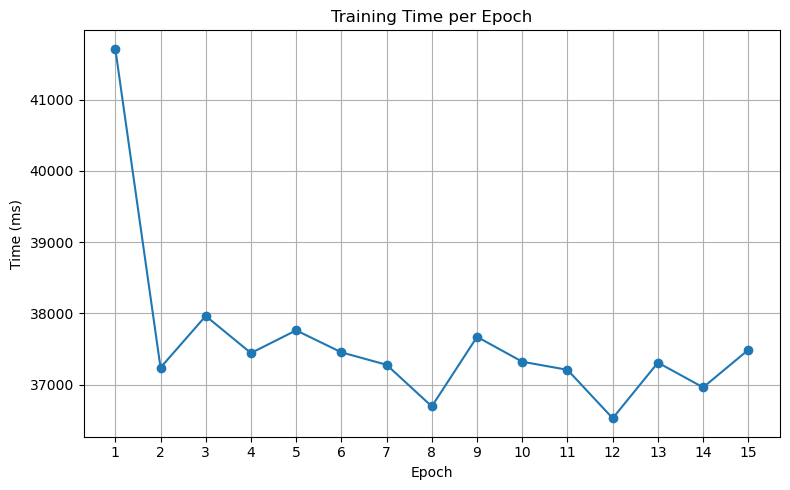

In [22]:
epoch_times = time_logger.epoch_times
epoch_numbers = np.arange(1, len(epoch_times) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epoch_numbers, epoch_times, marker='o')
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (ms)")
plt.grid(True)
plt.xticks(epoch_numbers)
plt.tight_layout()
plt.show()

### Model accuracy

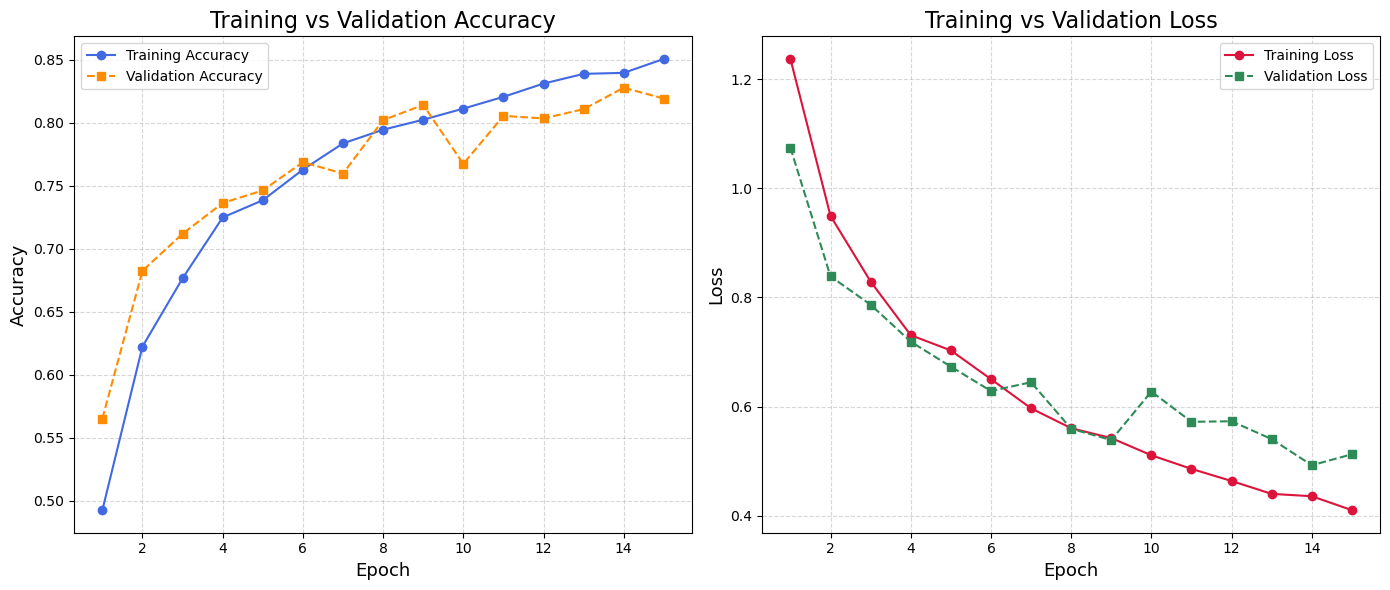

In [24]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(14,6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, marker='o', linestyle='-', color='royalblue', label='Training Accuracy')
    plt.plot(epochs, val_acc, marker='s', linestyle='--', color='darkorange', label='Validation Accuracy')
    plt.title("Training vs Validation Accuracy", fontsize=16)
    plt.xlabel('Epoch', fontsize=13)
    plt.ylabel('Accuracy', fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, marker='o', linestyle='-', color='crimson', label='Training Loss')
    plt.plot(epochs, val_loss, marker='s', linestyle='--', color='seagreen', label='Validation Loss')
    plt.title("Training vs Validation Loss", fontsize=16)
    plt.xlabel('Epoch', fontsize=13)
    plt.ylabel('Loss', fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_loss_accuracy(history)

### Confusion matrix

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


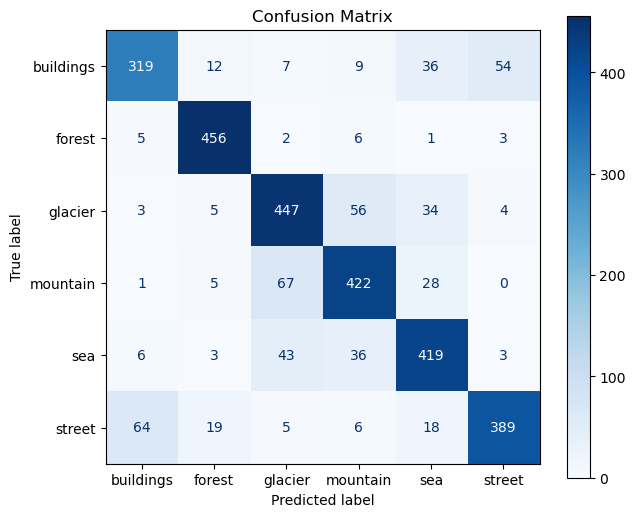

In [26]:
predicted_probs = model.predict(test_images_norm)
predicted_labels = np.argmax(predicted_probs, axis=1)

true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

fig, ax = plt.subplots(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', colorbar=True, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

### Precisio Recall F1-score 

In [43]:
report = classification_report(true_labels, predicted_labels, target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

   buildings     0.8015    0.7300    0.7641       437
      forest     0.9120    0.9641    0.9373       473
     glacier     0.7828    0.8142    0.7982       549
    mountain     0.7888    0.8069    0.7977       523
         sea     0.7817    0.8216    0.8011       510
      street     0.8587    0.7764    0.8155       501

    accuracy                         0.8192      2993
   macro avg     0.8209    0.8189    0.8190      2993
weighted avg     0.8195    0.8192    0.8185      2993



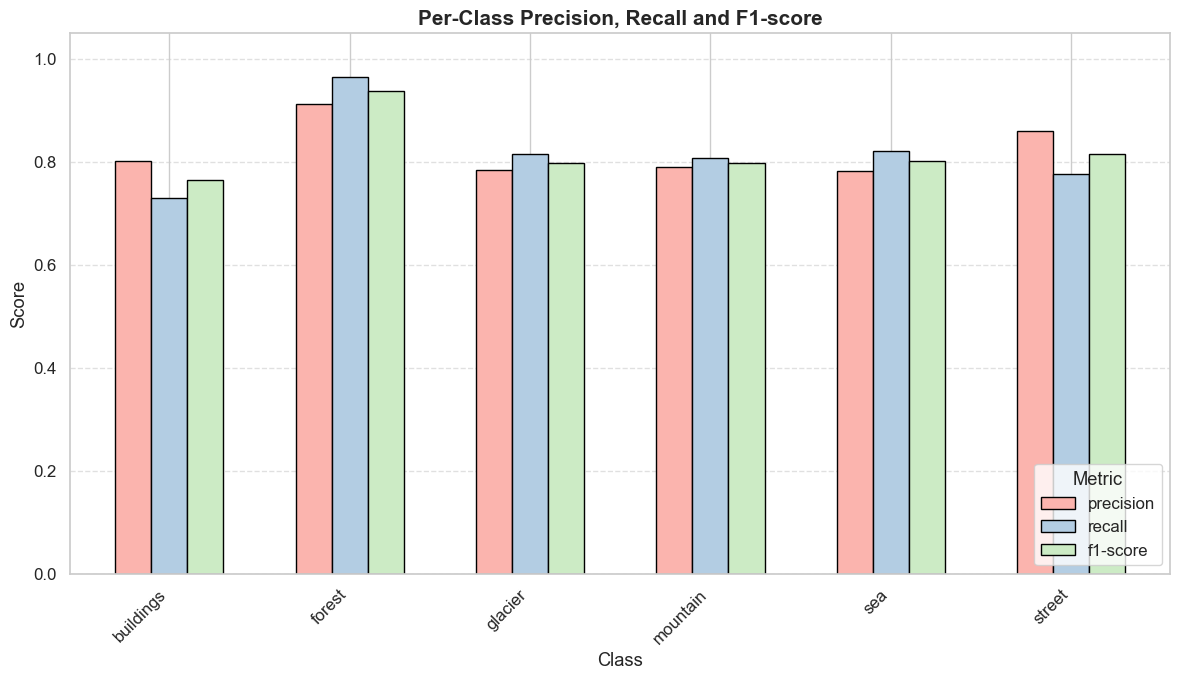

In [81]:
df = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(df).transpose().iloc[:-3][['precision', 'recall', 'f1-score']]

sns.set(style="whitegrid", font_scale=1.1)
soft_colors = sns.color_palette("Pastel1")[:3]

ax = df_report.plot(kind='bar', figsize=(12, 7), width=0.6, color=soft_colors, edgecolor='black')

plt.title('Per-Class Precision, Recall and F1-score', fontsize=15, weight='bold')
plt.ylabel('Score')
plt.xlabel('Class')
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', loc='lower right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Misclassified examples

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


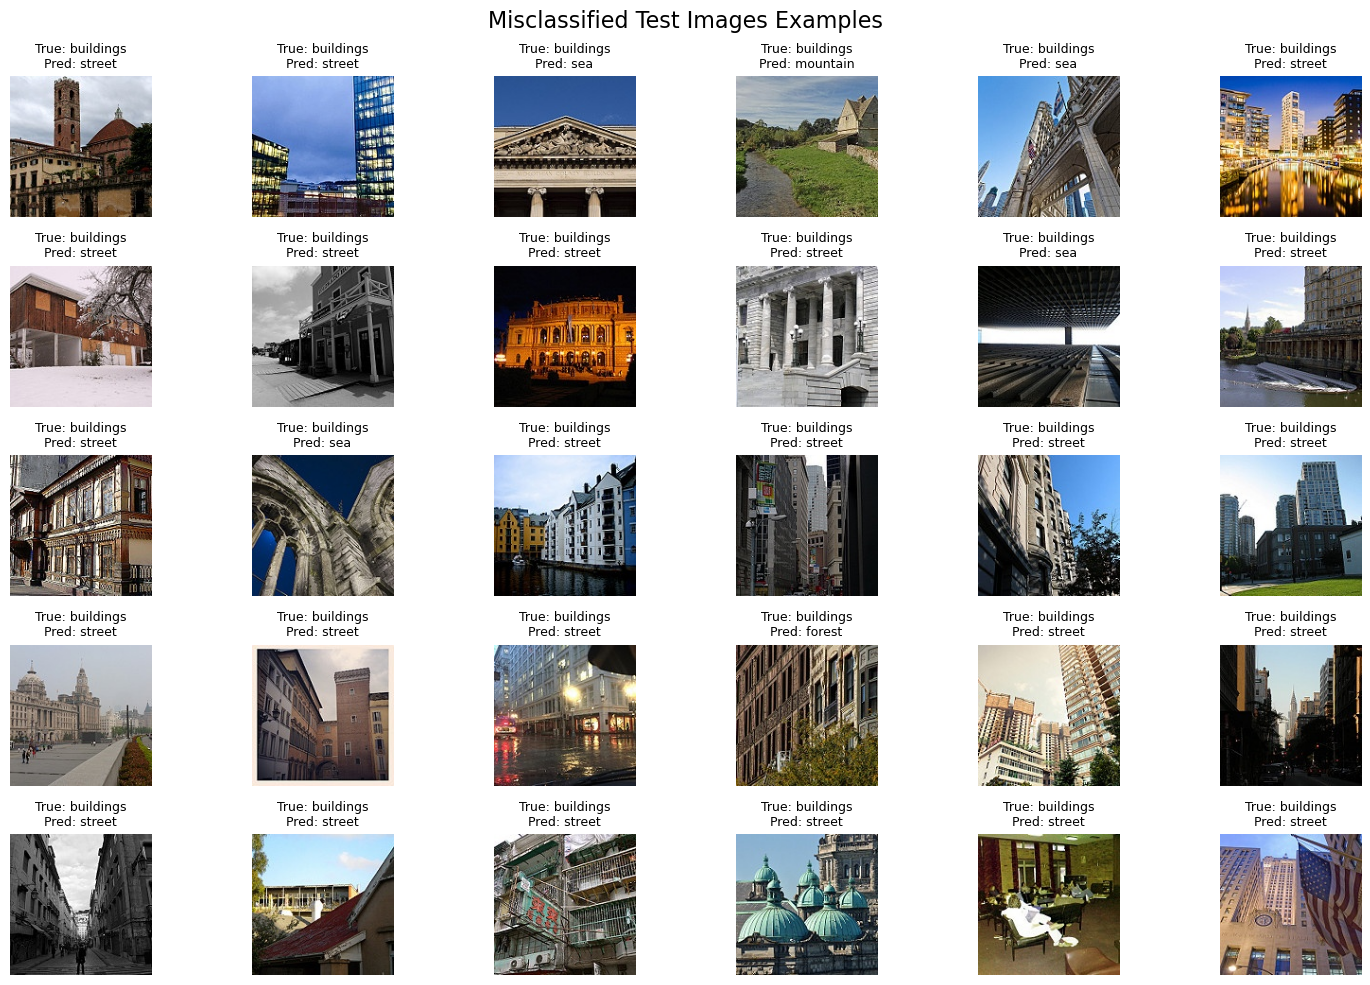

In [111]:
predicted_labels = np.argmax(model.predict(test_images_norm), axis=1)

true_labels = np.argmax(test_labels, axis=1)

misclassified_idx = np.where(predicted_labels != true_labels)[0]

misclassified_idx = misclassified_idx[:30]

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_idx):
    plt.subplot(5, 6, i+1)
    img = test_images[idx]
    img = (img).astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    true = class_names[true_labels[idx]]
    pred = class_names[predicted_labels[idx]]
    plt.title(f"True: {true}\nPred: {pred}", fontsize=9)

plt.suptitle("Misclassified Test Images Examples", fontsize=16)
plt.tight_layout()
plt.show()

### Model Saving

In [114]:
model.save("CNN_model.keras")

### Predictions on Unlabeled Images

In [7]:
pred_dir=r"D:\Project\PG Project\Data\Image Data\seg_pred\seg_pred"

def load_pred_images(pred_dir, image_size=(150, 150), max_images=None):
    images = []

    for file in sorted(os.listdir(pred_dir)):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(pred_dir, file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size)
            images.append(image)
            if max_images and len(images) >= max_images:
                break

    return np.array(images, dtype='float32')

In [11]:
pred_images = load_pred_images(pred_dir, image_size=IMAGE_SIZE)

In [19]:
CNN_loaded_model = load_model("CNN_model.keras")

In [21]:
pred_images_norm = pred_images / 255.0
pred_probs = CNN_loaded_model.predict(pred_images_norm)
pred_classes = np.argmax(pred_probs, axis=1)

228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step


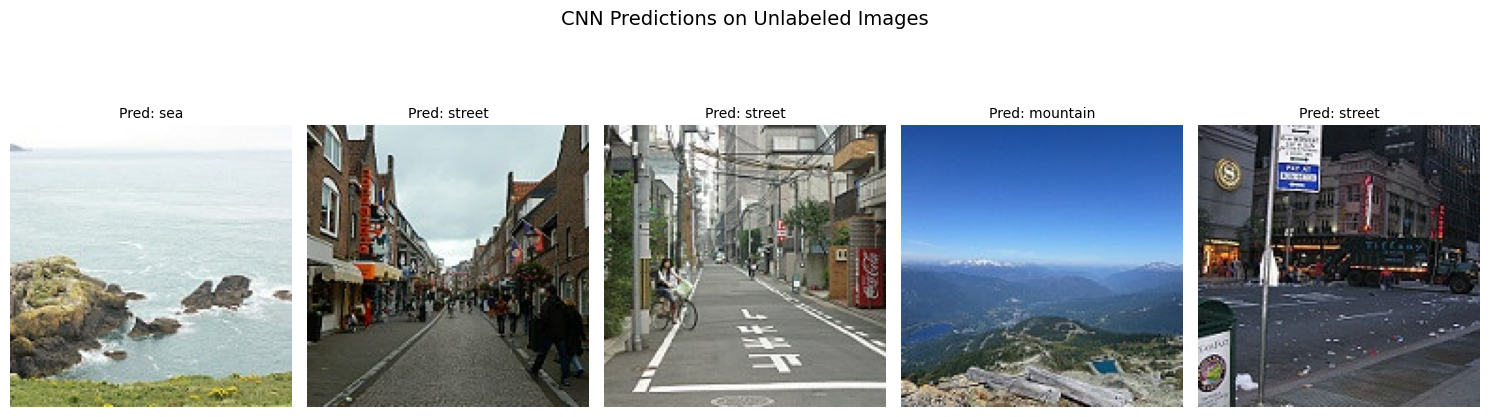

In [34]:
np.random.seed(40)
sample_idxs = np.random.choice(len(pred_images), 5, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_idxs):
    img = pred_images[idx]
    img = (img).astype('uint8')
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_names[pred_classes[idx]]}", fontsize=10)

plt.suptitle("CNN Predictions on Unlabeled Images", fontsize=14)
plt.tight_layout()
plt.show()

### Data augmentation(not applicable)

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [24]:
train_labels = to_categorical(train_labels, num_classes=6)
test_labels = to_categorical(test_labels, num_classes=6)

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True) / 255.0, y))
train_ds = train_ds.shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((test_images / 255.0, test_labels))
val_ds = val_ds.batch(128).prefetch(tf.data.AUTOTUNE)

In [26]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue2.keras', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_ds,  epochs=20, validation_data=(val_ds),
                   callbacks=callback_list)

# evalute the model
test_loss, test_acc = model.evaluate(val_ds, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 114s 934ms/step - accuracy: 0.5436 - loss: 1.7912 - val_accuracy: 0.1674 - val_loss: 4.0578
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 940ms/step - accuracy: 0.2205 - loss: 2.0338 - val_accuracy: 0.1674 - val_loss: 5.4944
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 944ms/step - accuracy: 0.2496 - loss: 1.7430 - val_accuracy: 0.1704 - val_loss: 1.8839
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 946ms/step - accuracy: 0.1425 - loss: 1.7005 - val_accuracy: 0.1674 - val_loss: 2.0028
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 111s 955ms/step - accuracy: 0.0782 - loss: 1.7409 - val_accuracy: 0.1704 - val_loss: 1.7910
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 109s 937ms/step - accuracy: 0.0210 - loss: 1.8436 - val_accuracy: 0.1704 - val_loss: 1.7901
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 947ms/step - accuracy: 0.0280 - loss: 1.8236 - val_accuracy: 0.1704 - val_loss: 1.7900
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 111s 948ms/step - accuracy: 0.0286 -